# Genomic clustering facilitates nuclear processing of suboptimal pri-miRNA loci

## Aim
- To see whether assisted processing found in mir-144~451 cluster would be extended to other subpotimal pri-miRNA loci

## Description
- SHAPE library was generated by Boseon Kim
- *In vitro* DROSHA processing library was generated by Kijun Kim

## Contents
1. Load pri-miRNA informations
2. Encode SHAPE structures
3. Extract structural features (loop size & UGU)
4. Compare pairing probability between *in silico* & SHAPE structures
5. Calculate processing efficiency
6. Compare processing efficiency between optimal and suboptimal pri-miRNAs
7. Parse miRNA annotation file to read miRNA clustering information
8. Compare miRNA clustering between optimal and suboptimal pri-miRNAs
9. Compare processing efficiency between (subopimal & clustered) and (suboptimal & not-clustered)

In [1]:
import time
today = time.strftime('%Y-%m-%d')
name = 'Seungchan Baek'
print 'Last revised by %s at %s.' % (name, today)

Last revised by Seungchan Baek at 2020-02-04.


In [2]:
WORKPATH = '/casa/bsc/projects/2_Structure-of-pri/2002_mir_cluster/'
%cd $WORKPATH

/casa/bsc/projects/2_Structure-of-pri/2002_mir_cluster


In [3]:
from __future__ import division
import sys; sys.path.append('/casa/bsc/notebooks/')
from basic import gen_result_dir
resultpath = gen_result_dir('results/')
print 'resultpath:', resultpath

resultpath: results/200204/


In [4]:
from __future__ import division
import pandas as pd
import numpy as np
import re
import gzip
from matplotlib import pyplot as plt
from collections import defaultdict, Counter
%matplotlib inline

---
## 1. Load pri-miRNA informations

In [5]:
from Bio import SeqIO

In [122]:
## 125mer pri-miRNA sequences
priseqd = { s.id:str(s.seq) for s in SeqIO.parse('1804_125mer_priseq.fa', 'fasta') }
ALLMIRS = priseqd.keys()
print len(ALLMIRS)

1881


In [7]:
## mature miRNA positions in 125mer pri-miRNA sequences
mirgenedb = pd.read_csv('1804_mirgenedb_v2.tbl', index_col=1)
mirgenedb = mirgenedb[~mirgenedb.index.duplicated(keep='first')].drop('None').sort_index()
dbnamed = mirgenedb.reset_index().set_index('Gene name')['MiRBase ID'].to_dict()
print len(dbnamed), dbnamed.items()[0]
mirgenedb.iloc[:5, :8]

534 ('Hsa-Mir-132-P1', 'hsa-mir-132')


,Gene name,Family,5p accession,3p accession,Chromosome,Start,End,Strand
MiRBase ID,,,,,,,,
hsa-let-7a-1,Hsa-Let-7-P6,LET-7,MIMAT0000062,MIMAT0004481,chr9,94175962,94176033,+
hsa-let-7a-2,Hsa-Let-7-P1,LET-7,MIMAT0000062,MIMAT0010195,chr11,122146523,122146589,-
hsa-let-7a-3,Hsa-Let-7-P7,LET-7,MIMAT0000062,MIMAT0004481,chr22,46112752,46112820,+
hsa-let-7b,Hsa-Let-7-P8,LET-7,MIMAT0000063,MIMAT0004482,chr22,46113691,46113765,+
hsa-let-7c,Hsa-Let-7-P3,LET-7,MIMAT0000064,MIMAT0026472,chr21,16539838,16539904,+


In [8]:
maturepos = defaultdict(lambda: (0, 0, 0, 0))
for s in SeqIO.parse('1804_mirgenedb_v2_matures.fa', 'fasta'):
    mat = s.id.replace('*','')
    matseq = str(s.seq)
    if re.search('v[2-9]', mat): 
        continue
    pridb, arm = mat.split('_')
    if pridb not in dbnamed:
        continue
    pri = dbnamed[pridb]
    priseq = priseqd[pri].replace('T','U')
    st = priseq.find(matseq) + 1
    en = st + len(matseq) - 1
    st5, en5, st3, en3 = maturepos[pri]
    if arm=='5p':
        maturepos[pri] = (st, en, st3, en3)
    else:
        maturepos[pri] = (st5, en5, st, en)
print len(maturepos)

534


In [52]:
repreRedund = {} # representative - redundant match
redundRepre = {}
for l in open('seq_redundant_pris.txt', 'rt'):
    mirs = [ mir for mir in l.strip().split() ]
    repreRedund[mirs[0]] = mirs[1:]
    for mir in mirs[1:]:
        redundRepre[mir] = mirs[0]

In [53]:
def add_redund(mirset):
    newset = []
    for mir in mirset:
        if mir in repreRedund:
            for redund in repreRedund[mir]:
                newset.append(redund)
        newset.append(mir)
    return list(set(newset))

---
## 2. Encode SHAPE structures

In [9]:
import os
from utils import *

In [10]:
LIBRARIES = [ 'rep1', 'rep2-1', 'rep2-2', 'rep2-3' ]
NUMSTRS = 3
MINBJ = -20
MAXBJ = -9
MINAJ = 18
STEMRANGE = [ 32, 33, 34, 35, 36, 37, 38 ]
DBMIRS = list(mirgenedb.index)
RNALEN = 125

In [11]:
def separate_ct(ctfile, ctpath, newpath):
    lns = open('%s/%s.ct' % (ctpath, ctfile), 'rt').readlines()
    rnaLen = int(lns[0].strip().split()[0])
    numsts = len(lns) // (rnaLen+1)
    for i in range(numsts):
        out = open('%s/%s_%s.ct' % (newpath, ctfile, i+1), 'wt')
        out.write(''.join(lns[(rnaLen+1)*i:(rnaLen+1)*(i+1)]))
        out.close()

In [12]:
for lib in LIBRARIES:
    ctpath = 'shape/%s/cts' % lib
    newpath = 'shape/%s/volatile' % lib
    if not os.path.exists(newpath):
        os.makedirs(newpath)

    allcts = [ f.split('.')[0] for f in os.listdir(ctpath) if f.endswith('.ct') ]
    #for ct in allcts:
    #    separate_ct(ct, ctpath, newpath)

In [35]:
libd = {}
for lib in LIBRARIES[::-1]:
    for s in SeqIO.parse('alignments/%s_suff.fa'%lib, 'fasta'):
        if s.id in DBMIRS:
            libd[s.id] = lib
suffmirs = libd.keys()
print len(add_redund(suffmirs))

443


In [36]:
normstrs = defaultdict(list)
for mir in suffmirs:
    st5, en5, st3, en3 = maturepos[mir]
    for i in range(1, 1+NUMSTRS):
        ctpath = 'shape/%s/volatile' % libd[mir]
        ctname = '%s_%s.ct' % (mir, i)
        if ctname in os.listdir(ctpath):
            ctfile = '%s/%s' % (ctpath, ctname)
            parsedstr = parse_ct_to_str(st5, en3, RNALEN, ctfile)
            ov = measure_overhang(parsedstr, st5, en3)  
            if 0 <= ov <= 4:
                normstrs[mir].append((parsedstr, ctname))
print len(add_redund(normstrs))

427


In [16]:
def separate_str(parsedstr, pres, pree):
    flank5 = parsedstr[:pres-1]
    ustem5 = parsedstr[pres-1:parsedstr.rfind('L')]
    flank5Len = count_len(flank5)
    for i in range(1, RNALEN):
        if count_len(parsedstr[-i:]) == flank5Len:
            flank3 = parsedstr[-i:][::-1]
            ustem3 = parsedstr[parsedstr.rfind('L'):-i][::-1]
            return flank5, ustem5, ustem3, flank3

In [17]:
def list_juncs(strt):
    jcClose, jcOpen = {}, {}
    for i in range(1, len(strt)):
        st5p, st3p = strt[i-1], strt[i]
        if st5p in 'AFLSX' and st3p == 'M':# and strt[i-2:i+1] != 'MAM':
            jcClose[count_len(strt[i:])] = i
        if st5p == 'M' and st3p in 'AFLSX':# and strt[i-1:i+2] != 'MAM':    
            jcOpen[count_len(strt[:i])] = i
    return jcClose, jcOpen

In [18]:
def get_junc_infos(parsedstr, pres, pree):
    flank5, ustem5, ustem3, flank3 = separate_str(parsedstr, pres, pree)
    jcflank5 = list_juncs(flank5)[0]
    jcflank3 = list_juncs(flank3)[0]
    jcstem5 = list_juncs(ustem5)[1]
    jcstem3 = list_juncs(ustem3)[1]
    
    juncPos = defaultdict(list)
    for lencnt, nuccnt in jcflank5.items():
        juncPos[-lencnt].append(nuccnt) # 5p of closing pair (0-base)
    for lencnt, nuccnt in jcflank3.items():
        juncPos[-lencnt].append(RNALEN-1-nuccnt) # 3p of closing pair (0-base)
    for lencnt, nuccnt in jcstem5.items():
        juncPos[lencnt].append(pres-2+nuccnt) # 5p of closing pair (0-base)
    for lencnt, nuccnt in jcstem3.items():
        juncPos[lencnt].append(pres+len(ustem5+ustem3)-1-nuccnt) # 3p of closing pair (0-base)

    sscnt = defaultdict(list)
    for flank in [ flank5, flank3 ]:
        mpos = [ i for i, s in enumerate(flank) if s=='M' ]
        for mp1, mp2 in zip(mpos[:-1], mpos[1:]):
            sscnt[-count_len(flank[mp2:])].append(mp2-mp1-1)
    sscnt[-count_len(flank5[flank5.find('M'):])] = [ 1, 1, 0 ]

    for ustem in [ ustem5, ustem3 ]:
        mpos = [ i for i, s in enumerate(ustem) if s=='M' ]
        for mp1, mp2 in zip(mpos[:-1], mpos[1:]):
            sscnt[count_len(ustem[:mp1])+1].append(mp2-mp1-1)
    sscnt[count_len(ustem5[:ustem5.find('L')])] = [ parsedstr.count('L')-3 ]
    return juncPos, { pos:sscnt[pos] for pos in juncPos.keys() }

In [23]:
def find_js(parsedstr, pres, pree):
    juncPos, sscnt = get_junc_infos(parsedstr, pres, pree)
    loopLen = parsedstr.count('L')
    js = []
    for aj in juncPos.keys():
        for bj in juncPos.keys():
            bjpos = juncPos[bj]
            if len(bjpos) == 2:
                bj5p, bj3p = bjpos
            elif bjpos[0] > 60:
                bj5p = find_opposite(parsedstr, bjpos[0], '3p')
                bj3p = bjpos[0]
            else:
                bj5p = bjpos[0]
                bj3p = find_opposite(parsedstr, bjpos[0], '5p')
            if aj-bj in STEMRANGE and MINBJ<bj<=MAXBJ and aj>=MINAJ and \
            'X' not in parsedstr[bj5p:bj3p+1]:
                js.append((bj,aj,sscnt[bj],sscnt[aj],juncPos[bj],juncPos[aj],loopLen))
    return js

In [21]:
def find_opposite(strt, mpos, strand): # pos 0-base
    if strand == '5p':
        mcnt = strt[:mpos+1].count('M')
        for i in range(mpos, 125):
            if strt[i] == 'M' and strt[i:].count('M') == mcnt:
                return i
    else:
        mcnt = strt[mpos:].count('M')
        for i in range(mpos):
            if strt[:i+1].count('M') == mcnt:
                return i

In [64]:
beststrs = {}
for mir, strs in normstrs.items():
    st5, en5, st3, en3 = maturepos[mir]
    canostrs = [ (st, fname) for (st, fname) in strs if find_js(st, st5, en3) ]
    if canostrs:
        beststr = canostrs[0]
    else:
        beststr = strs[0]
    beststrs[mir] = beststr
    if mir in repreRedund:
        beststrs[repreRedund[mir][0]] = beststr
print beststrs['hsa-let-7a-1']

('MMMMMMMMMMMSAMMMMSSMMMMMAMMMMMMMMMMMMMMMMMMMMMAAAAAMMMAASMMMMLLLLMMMMSMMMMMMMMMMMMMMMMMMMMMMMMMMMMMSSMMMMSMMMAAAAAAAMMMMMMMMF', 'hsa-let-7a-1_1.ct')


---
## 3. Extract structural features (loop size & UGU)

In [60]:
strinfos = {}
for mir in suffmirs:
    st5, en5, st3, en3 = maturepos[mir]
    if mir not in beststrs:
        continue
    parsedstr = beststrs[mir][0]
    jcs = find_js(parsedstr, st5, en3)
    if jcs:
        ssmax = max([ sum(x[2][:2]+x[3]) for x in jcs ])
        jcsmax = [ x for x in jcs if sum(x[2][:2]+x[3])==ssmax ]
        strinfos[mir] = sorted(jcsmax, key=lambda x: abs(x[1]-22)+abs(x[0]+13))[0]
        if mir in repreRedund:
            strinfos[repreRedund[mir][0]] = strinfos[mir]
canomirs = strinfos.keys()
print len(strinfos)

401


In [69]:
def get_loop_size(mir):
    bj, aj, bjc, ajc, bjpos, ajpos, ll = strinfos[mir]
    parsedstr = beststrs[mir][0]
    if len(ajpos) == 2:
        aj5p, aj3p = ajpos
    elif ajpos[0] > 60:
        aj5p = find_opposite(parsedstr, ajpos[0], '3p')
        aj3p = ajpos[0]
    else:
        aj5p = ajpos[0]
        aj3p = find_opposite(parsedstr, ajpos[0], '5p')
    simpleloop = ll
    terminalloop = aj3p - aj5p - 1
    return simpleloop, terminalloop

In [70]:
simpls, termls = zip(*[ get_loop_size(mir) for mir in canomirs ])
simpls = dict(zip(canomirs, simpls))
termls = dict(zip(canomirs, termls))
print len(termls)

401


In [62]:
def has_ugu(mir, ugurange):
    bj, aj, bjc, ajc, bjpos, ajpos, ll = strinfos[mir]
    parsedstr = beststrs[mir][0]
    st5, en5, st3, en3 = maturepos[mir]
    priseq = priseqd[mir].replace('T','U')
    if ajpos[0] > 60:
        aj5p = find_opposite(parsedstr, ajpos[0], '3p')
    else:
        aj5p = ajpos[0]
        
    for i in range(st5-1, parsedstr.rfind('L')):
        subseq = priseq[i:i+3]
        dist = count_len(parsedstr[st5-1:i+1]) + parsedstr[st5-1:i+1].count('L')
        if subseq=='UGU' and dist in ugurange:
            return True
    return False

In [65]:
ugurange = [ 20, 21, 22, 23, 24 ]
ugumirs = [ mir for mir in canomirs if has_ugu(mir, ugurange) ]
print len(ugumirs)

133


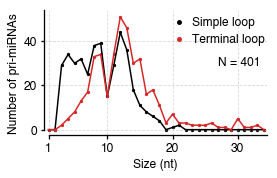

In [101]:
fig, ax = plt.subplots(1, 1, figsize=(4,2.3))

vs, tks = np.histogram(simpls.values(), bins=np.arange(0, 35)+.5)
tks = (tks[1:]+tks[:-1])/2
ax.scatter(tks, vs, s=5, color='black')
ax.plot(tks, vs, color='black')

vs, tks = np.histogram(termls.values(), bins=np.arange(0, 35)+.5)
tks = (tks[1:]+tks[:-1])/2
ax.scatter(tks, vs, s=5, color='tab:red')
ax.plot(tks, vs, color='tab:red')
ax.scatter([-1], [0], s=15, color='black', label='Simple loop')
ax.scatter([-1], [0], s=15, color='tab:red', label='Terminal loop')
ax.set_xlabel('Size (nt)', fontsize=12)
ax.set_ylabel('Number of pri-miRNAs', fontsize=12)
ax.text(27, 29, 'N = %s'%len(canomirs), fontsize=12)
ax.tick_params(labelsize=12, width=1.3)
ax.legend(prop={'size':12}, frameon=False, handletextpad=.05, labelspacing=.4, loc=(.53, .68))
ax.spines['bottom'].set_bounds(1, 34.5)
ax.spines['left'].set_bounds(0, 54)
ax.set_xlim(.3, 34.5)
ax.set_ylim(-2.5, 54)
ax.set_xticks([1,10,20,30])
ax.grid()
#fig.savefig(resultpath + '190624_suppl_loop-dist.pdf')

---
## 4. Compare pairing probability between in silico & SHAPE structures

In [73]:
bpexcel = pd.ExcelFile('1902_pairing_probs.xlsx')
insiltbl = bpexcel.parse(sheet_name='In silico', index_col=0).T
shapetbl = bpexcel.parse(sheet_name='SHAPE', index_col=0).T
insiltbl.iloc[:3, :10]

,1,2,3,4,5,6,7,8,9,10
hsa-let-7a-1,0.979560,0.996100,0.999966,0.999983,0.999492,0.999093,0.999419,0.976996,0.491350,0.553855
hsa-let-7a-2,0.001003,0.947648,0.997825,0.998169,0.955574,0.884709,0.914583,0.990496,0.987075,0.019446
hsa-let-7a-3,0.980708,0.994981,0.999009,0.996163,0.001841,0.982094,0.992547,0.956503,0.002694,0.002762


In [75]:
bpprobs5 = defaultdict(list)
bpprobi5 = defaultdict(list)
for mir in canomirs:
    st5, en5, st3, en3 = maturepos[mir]
    for i in range(15):
        bpprobs5[i].append(shapetbl.loc[mir, en5+i])
        bpprobi5[i].append(insiltbl.loc[mir, en5+i])

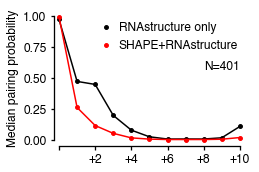

In [102]:
inps = [ bpprobs5[i] for i in range(11) ]
inpi = [ bpprobi5[i] for i in range(11) ]
fig, ax = plt.subplots(1, 1, figsize=(3.5,2.5))
ax.plot(range(1,12), map(np.median, inpi), color='black')
ax.plot(range(1,12), map(np.median, inps), color='red')
ax.scatter(range(1,12), map(np.median, inpi), s=15, color='black', label='RNAstructure only')
ax.scatter(range(1,12), map(np.median, inps), s=15, color='red', label='SHAPE+RNAstructure')
ax.spines['left'].set_bounds(0,1)
ax.spines['bottom'].set_bounds(1,11)
ax.set_xlim(.7, 11.5)
ax.set_ylim(-.05, 1.05)
ax.set_xticks(range(1,12,2))
ax.set_xticklabels(['','+2','+4','+6','+8','+10'])
ax.set_ylabel('Median pairing probability', fontsize=12)
ax.legend(prop={'size':12}, frameon=False, handletextpad=.05)
ax.text(9, .57, 'N=401', fontsize=12)
ax.tick_params(width=1.3, labelsize=12)
#fig.savefig(resultpath + '190612_suppl_pairing-prob_5p.pdf')

In [78]:
bpprobs3 = defaultdict(list)
bpprobi3 = defaultdict(list)
for mir in canomirs:
    st5, en5, st3, en3 = maturepos[mir]
    for i in range(15):
        bpprobs3[i].append(shapetbl.loc[mir, st3-i])
        bpprobi3[i].append(insiltbl.loc[mir, st3-i])

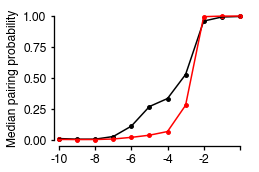

In [103]:
inps = [ bpprobs3[i] for i in range(11) ][::-1]
inpi = [ bpprobi3[i] for i in range(11) ][::-1]
fig, ax = plt.subplots(1, 1, figsize=(3.5,2.5))
ax.plot(range(1,12), map(np.median, inpi), color='black')
ax.plot(range(1,12), map(np.median, inps), color='red')
ax.scatter(range(1,12), map(np.median, inpi), s=15, color='black', label='RNAstructure only')
ax.scatter(range(1,12), map(np.median, inps), s=15, color='red', label='SHAPE+RNAstructure')
ax.spines['left'].set_bounds(0,1)
ax.spines['bottom'].set_bounds(1,11)
ax.set_xlim(.7, 11.5)
ax.set_ylim(-.05, 1.05)
ax.set_xticks(range(1,12,2))
ax.set_xticklabels([-10,-8,-6,-4,-2,''])
ax.set_ylabel('Median pairing probability', fontsize=12)
ax.tick_params(width=1.3, labelsize=12)
#fig.savefig(resultpath + '190612_suppl_pairing-prob_3p.pdf')

---
## 5. Calculate processing efficiency

In [108]:
inptbl = pd.read_csv('1808_input.csv', index_col=0)
inpsum = pd.DataFrame()
for sample in [ '1704', '1708', '1807pcr' ]:
    inpsum[sample] = inptbl['%s-rep1'%sample] + inptbl['%s-rep2'%sample]
inpsum = inpsum.sort_index(axis=1).astype(int)
inpsum.head()

,1704,1708,1807pcr
hsa-let-7a-1,1373,0,0
hsa-let-7a-2,2223,0,0
hsa-let-7a-3,2971,0,0
hsa-let-7b,2258,0,0
hsa-let-7c,1582,0,0


In [109]:
unctbl = pd.read_csv('1808_uncleaved.csv', index_col=0)
uncsum = pd.DataFrame()
for tri in [ '1704-', '1708-', '1807pcr-' ]:
    uncsum[re.sub('-$', '', tri)] = unctbl['%srep1'%tri] + unctbl['%srep2'%tri]
uncsum = uncsum.astype(int)
uncsum.head()

,1704,1708,1807pcr
hsa-let-7a-1,30,0,0
hsa-let-7a-2,252,0,0
hsa-let-7a-3,4654,0,0
hsa-let-7b,2618,0,0
hsa-let-7c,1052,0,0


In [110]:
SAMPLES = [ '1704', '1708', '1807pcr' ]
CUTOFF = 100
relmirs = { sample:list(inpsum[inpsum[sample]>CUTOFF].index) for sample in SAMPLES }

In [124]:
fc = pd.DataFrame(index=sorted(ALLMIRS))
for sample in SAMPLES:
    rel = relmirs[sample]
    fc[sample] = uncsum[sample].reindex(rel) / inpsum[sample].reindex(rel)
fc.head(3)

,1704,1708,1807pcr
hsa-let-7a-1,0.021850,NaN,NaN
hsa-let-7a-2,0.113360,NaN,NaN
hsa-let-7a-3,1.566476,NaN,NaN


In [125]:
adjpe = 1 - fc.apply(lambda x: x/np.percentile(x.dropna(), 99))
adjpe.head()

,1704,1708,1807pcr
hsa-let-7a-1,0.989094,NaN,NaN
hsa-let-7a-2,0.943417,NaN,NaN
hsa-let-7a-3,0.218110,NaN,NaN
hsa-let-7b,0.421281,NaN,NaN
hsa-let-7c,0.668082,NaN,NaN


In [129]:
pe = { mir:max(0, adjpe.loc[mir].dropna()[0]) for mir in canomirs 
       if mir in adjpe.index and any(adjpe.loc[mir].fillna(0)>0) }
print len(pe)

398


---
## 6. Compare processing efficiency between optimal and suboptimal pri-miRNAs

In [133]:
from scipy.stats import mannwhitneyu

In [131]:
THRES = 7
subopt = [ mir for mir in canomirs if termls[mir]<=THRES and mir not in ugumirs ]
opt = [ mir for mir in canomirs if termls[mir]>THRES and mir not in ugumirs ]
print len(subopt), len(opt)

28 240


Text(0.3,50,u'p=0.036')

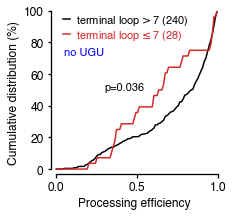

In [147]:
pesub = [ pe[mir] for mir in subopt ]
peopt = [ pe[mir] for mir in opt ]
fig, ax = plt.subplots(1, 1, figsize=(3,3))
vs, ts = np.histogram(peopt, bins=np.arange(0, 1.001, .01))
ax.plot((ts[1:]+ts[:-1])/2, vs.cumsum()/vs.sum()*100, color='black', 
        label=r'terminal loop$ > $7 (%s)'%len(peopt))

vs, ts = np.histogram(pesub, bins=np.arange(0, 1.001, .01))
ax.plot((ts[1:]+ts[:-1])/2, vs.cumsum()/vs.sum()*100, color='tab:red', 
        label='terminal loop$ \leq $7 (%s)'%len(pesub))

ax.tick_params(labelsize=12, width=1.3)
leg = ax.legend(prop={'size':11}, frameon=False, labelspacing=.1, handlelength=.6, 
                handletextpad=.5, loc=(.05, .78))
leg.get_texts()[1].set_color('tab:red')
ax.spines['bottom'].set_bounds(0, 1)
ax.spines['left'].set_bounds(0, 100)
ax.set_xlim(-.03, 1)
ax.set_ylim(-3, 100)
ax.set_xlabel('Processing efficiency', fontsize=12)
ax.set_ylabel('Cumulative distribution (%)', fontsize=12)
ax.text(.05, 72, 'no UGU', color='blue', fontsize=11)

p = mannwhitneyu(peopt, pesub)[1]
ax.text(.3, 50, 'p=%.3f'%p, fontsize=11)
#fig.savefig(resultpath + '190624_fig3a_loop-pe-nougu.pdf')

---
## 7. Parse miRNA annotation file to read miRNA clustering information

In [148]:
BEDCOLS = 'chr start end mir . strand'.split()
gentbl = pd.read_table('1804_premiR+-50_annotation.bed', sep='\t', names=BEDCOLS)

In [149]:
mirgenome = {}
for i, row in gentbl.iterrows():
    chrom, st, en, mir, x, strand = row
    mirgenome[mir] = (chrom, st+50, en-50, strand)

In [150]:
def find_closest_mir(mir):
    chrom, start, end, strand = mirgenome[mir]
    sameChrStr = [ m for m in mirgenome
                   if mirgenome[m][0]==chrom and mirgenome[m][3]==strand and m!=mir ]
    if not sameChrStr:
        print mir, 'no miR in same strand of same chromosome'
        return ('None', 10**7)
    dists = []
    for m in sameChrStr:
        st, en = mirgenome[m][1:3]
        if end < st:
            dists.append((m, (st-end)))
        elif en < start:
            dists.append((m, (start-en)))
        else:
            print 'overlapping miR', start, end, st, en, mir, m
            dists.append((m, 0))
            continue
            
    minDist = sorted(dists, key=lambda x:abs(x[1]))[0]
    return minDist

In [152]:
neighDist = {}
for mir in canomirs:
    neighDist[mir] = find_closest_mir(mir)[1]
print len(neighDist)

401


---
## 8. Compare miRNA clustering between optimal and suboptimal pri-miRNAs

In [153]:
clstsub = [ neighDist[mir] for mir in subopt if neighDist[mir]<10**6 ]
clstopt = [ neighDist[mir] for mir in opt if neighDist[mir]<10**6 ]
print len(clstsub), len(clstopt)

22 180


Text(140,65,u'p=0.010')

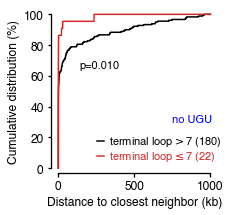

In [154]:
fig, ax = plt.subplots(1, 1, figsize=(3,3))
vs, tks = np.histogram(clstopt, bins=np.arange(0, 10**6+1, 10**3))
tks = (tks[1:]+tks[:-1])/2
ax.plot([0]+list(tks/10**3), [0]+list(vs.cumsum()/vs.sum()*100), color='black', 
        label=r'terminal loop$ > $7 (%s)'%len(clstopt))

vs, tks = np.histogram(clstsub, bins=np.arange(0, 10**6+1, 10**3))
tks = (tks[1:]+tks[:-1])/2
ax.plot([0]+list(tks/10**3), [0]+list(vs.cumsum()/vs.sum()*100), color='tab:red', 
        label='terminal loop$ \leq $7 (%s)'%len(clstsub))

ax.tick_params(labelsize=12, width=1.3)
leg = ax.legend(prop={'size':11}, frameon=False, labelspacing=.1, handlelength=.6, 
                handletextpad=.5, loc=(.25, .03))
leg.get_texts()[1].set_color('tab:red')
ax.spines['bottom'].set_linewidth(1.3)
ax.spines['left'].set_linewidth(1.3)
ax.spines['bottom'].set_bounds(0, 10**3)
ax.spines['left'].set_bounds(0, 100)
ax.set_xlim(-50, 1050)
ax.set_ylim(-3, 103)
ax.set_xlabel('Distance to closest neighbor (kb)', fontsize=12)
ax.set_ylabel('Cumulative distribution (%)', fontsize=12)
ax.text(750, 30, 'no UGU', fontsize=11, color='blue')

p = mannwhitneyu(clstsub, clstopt)[1]
ax.text(140, 65, 'p=%.3f'%p, fontsize=11)
#fig.savefig(resultpath + '190624_fig3b1_dist-neighbor-nougu.pdf')

Text(1.9,30,u'no UGU')

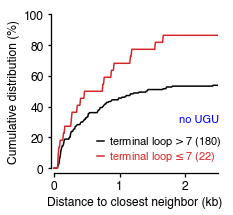

In [155]:
fig, ax = plt.subplots(1, 1, figsize=(3,3))
vs, tks = np.histogram(clstopt, bins=np.arange(0, 10**6+1, 10))
tks = (tks[1:]+tks[:-1])/2
ax.plot([0]+list(tks/10**3), [0]+list(vs.cumsum()/vs.sum()*100), color='black', 
        label=r'terminal loop$ > $7 (%s)'%len(clstopt))

vs, tks = np.histogram(clstsub, bins=np.arange(0, 10**6+1, 10))
tks = (tks[1:]+tks[:-1])/2
ax.plot([0]+list(tks/10**3), [0]+list(vs.cumsum()/vs.sum()*100), color='tab:red', 
        label='terminal loop$ \leq $7 (%s)'%len(clstsub))

ax.tick_params(labelsize=12, width=1.3)
leg = ax.legend(prop={'size':11}, frameon=False, labelspacing=.1, handlelength=.6, 
                handletextpad=.5, loc=(.25, .03))
leg.get_texts()[1].set_color('tab:red')
ax.spines['bottom'].set_linewidth(1.3)
ax.spines['left'].set_linewidth(1.3)
ax.spines['bottom'].set_bounds(0, 2.5)
ax.spines['left'].set_bounds(0, 100)
ax.set_xlim(-.05, 2.5)
ax.set_ylim(-3, 103)
ax.set_xlabel('Distance to closest neighbor (kb)', fontsize=12)
ax.set_ylabel('Cumulative distribution (%)', fontsize=12)
ax.text(1.9, 30, 'no UGU', fontsize=11, color='blue')
#fig.savefig(resultpath + '190624_fig3b1_dist-neighbor-nougu_zoom.pdf')

---
## 9. Compare processing efficiency between (subopimal & clustered) and (suboptimal & not-clustered)

In [156]:
CLST = 2000
subclst = [ mir for mir in subopt if mir not in ugumirs and neighDist[mir]<=CLST ]
subsolo = [ mir for mir in subopt if mir not in ugumirs and neighDist[mir]>CLST ]
opt = [ mir for mir in opt if mir not in ugumirs ]
print len(subclst), len(subsolo), len(opt)

19 9 240


Text(0.04,55,u'no UGU')

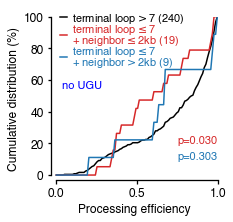

In [158]:
peopt = [ pe[mir] for mir in opt ]
pesubclst = [ pe[mir] for mir in subclst ]
pesubsolo = [ pe[mir] for mir in subsolo ]

fig, ax = plt.subplots(1, 1, figsize=(3,3))
vs, ts = np.histogram(peopt, bins=np.arange(0, 1.001, .01))
ax.plot((ts[1:]+ts[:-1])/2, vs.cumsum()/vs.sum()*100, color='black', 
        label=r'terminal loop$ > $7 (%s)'%len(peopt))

vs, ts = np.histogram(pesubclst, bins=np.arange(0, 1.001, .01))
ax.plot((ts[1:]+ts[:-1])/2, vs.cumsum()/vs.sum()*100, color='tab:red', 
        label='terminal loop$ \leq $7\n+ neighbor$ \leq $2kb (%s)'%len(pesubclst))

vs, ts = np.histogram(pesubsolo, bins=np.arange(0, 1.001, .01))
ax.plot((ts[1:]+ts[:-1])/2, vs.cumsum()/vs.sum()*100, color='tab:blue', 
        label='terminal loop$ \leq $7\n+ neighbor$ > $2kb (%s)'%len(pesubsolo))

ax.tick_params(labelsize=12, width=1.3)
leg = ax.legend(prop={'size':11}, frameon=False, labelspacing=-.25, handlelength=.6, 
                handletextpad=.5, loc=(.03, .65))
leg.get_texts()[1].set_color('tab:red')
leg.get_texts()[2].set_color('tab:blue')
leg.get_texts()[1].set_linespacing(.7)
leg.get_texts()[2].set_linespacing(.7)
ax.spines['bottom'].set_bounds(0, 1)
ax.spines['left'].set_bounds(0, 100)
ax.set_xlim(-.03, 1)
ax.set_ylim(-3, 100)
ax.set_xlabel('Processing efficiency', fontsize=12)
ax.set_ylabel('Cumulative distribution (%)', fontsize=12)

p1 = mannwhitneyu(pesubclst, peopt, alternative='less')[1]
p2 = mannwhitneyu(pesubsolo, peopt, alternative='less')[1]
ax.text(.75, 20, 'p=%.3f'%p1, fontsize=11, color='tab:red')
ax.text(.75, 10, 'p=%.3f'%p2, fontsize=11, color='tab:blue')
ax.text(.04, 55, 'no UGU', fontsize=11, color='blue')
#fig.savefig(resultpath + '191028_loop-pe-neighbor_ugu.pdf')